# Hello world: Two coins

In [2]:
import math
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

## Helper Functions

In [12]:
def nCr(n,r):
    """
    A naive implementation for calculating the combination number C_n^r.

    Args:
        n: int, the total number
        r: int, the number of selected

    Returns:
        C_n^r, the combination number
    """
    f = math.factorial
    return f(n) / f(r) / f(n - r)


def binomial(x, n, p):
    """
    The bionomial distribution C_n^x p^x (1-p)^(n-x)

    Args:
        n: int, the total number
        x: int, the number of selected
        p: float, the probability

    Returns:
        The bionomial probability C_n^x p^x (1-p)^(n-x)
    """
    return nCr(n, x) * (p**x) * (1 - p)**(n - x)


def log_likelihood(X, n, theta):
    """
    Calculates the log likelihood function for the two coins problem.

    Args:
        X: np.array of shape (n_trials,), dtype int, 
            the observations (number of heads at each trial).
        n: int, total number of tosses per trial.
        theta: tuple of (lambda, pA, pB), where 
            - lambda: float, the prior probability of selecting coin A (=1/2)
            - pA: float, coin A's probability of showing head
            - pB: float, coin B's probability of showing head

    Returns:
        log-likelihood 
            f(theta) = sum_i log sum_zi P(xi, zi; theta)
                     = sum_i log[ lam ( nCr(10, xi) pA^xi (1-pA)^(10-xi) )
                                + (1-lam) ( nCr(10, xi) pB^xi (1-pB)^(10-xi) ) ]
    """
    (lam, p1, p2) = theta
    ll = 0
    for x in X:
        ll += np.log(
            lam * binomial(x, n, p1) + (1 - lam) * binomial(x, n, p2)
        )
    return ll


def ELBO(X, n, Q, theta):
    """
    Calculates the ELBO for the two coins problem.

    Args:
        X: np.array of shape (n_trials,), dtype int, 
            the observations (number of heads at each trial).
        n: int, total number of tosses per trial.
        Q: np.array of shape (n_trials, 2), dtype float,
            the hidden posterior q(z) (z = A, B) computed in the E-step.
        theta: tuple of (lambda, pA, pB), where 
            - lambda: float, the prior probability of selecting coin A (=1/2)
            - pA: float, coin A's probability of showing head
            - pB: float, coin B's probability of showing head

    Returns:
        ELBO (Evidence Lower Bound)
            g(theta) = sum_i sum_zi Q(zi) log( P(xi, zi; theta) / Q(zi) )
    """
    (lam, p1, p2) = theta
    elbo = 0
    for i, x in enumerate(X):
        elbo += Q[i, 0] * np.log(lam * binomial(x, n, p1) / Q[i, 0])
        elbo += Q[i, 1] * np.log((1 - lam) * binomial(x, n, p2) / Q[i, 1])
    return elbo


def plot_coin_function(grid_fn, title, path=[]):
    """
    Plots a function wrt pA, pB using 2D contours.
    Reference: https://nbviewer.jupyter.org/github/eecs445-f16/umich-eecs445-f16/blob/master/handsOn_lecture17_clustering-mixtures-em/handsOn_lecture17_clustering-mixtures-em.ipynb#Problem:-implement-EM-for-Coin-Flips

    Args:
        grid_fn: callable, a function that takes pA, pB as inputs 
            and returns the function value at that point.
        title: string, title of the plot.
        path: (optional) A list of tuple of (pA, pB) that are visited in the EM iterations.
            Visualized as line segments if not empty.

    Returns:
        Shows the figure and returns None.
    """
    xvals = np.linspace(0.01, 0.99, 100)
    yvals = np.linspace(0.01, 0.99, 100)
    xx, yy = np.meshgrid(xvals, yvals)
    
    grid = np.zeros([len(xvals), len(yvals)])
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            grid[j, i] = grid_fn(xvals[i], yvals[j])

    plt.figure(figsize=(10, 8), dpi=150)
    C = plt.contour(xx, yy, grid, 1000)
    cbar = plt.colorbar(C)
    plt.title(title, fontsize=20)
    plt.xlabel(r"$p_A$", fontsize=20)
    plt.ylabel(r"$p_B$", fontsize=20)

    if path:
        p1, p2 = zip(*path)
        plt.plot(p1, p2, 'g+-')
        plt.text(p1[0] - 0.15, p2[0] - 0.05, 'start:\n$p_A={}$\n$p_B={}$'.format(p1[0], p2[0]), color='green', size=15)
        plt.text(p1[-1] + 0.0, p2[-1] + 0.02, 'end:\n$p_A={:.3f}$\n$p_B={:.3f}$'.format(p1[-1], p2[-1]), color='green', size=15)
    
    plt.show()


def plot_coin_likelihood(X, n, path=[]):
    """
    Plots the coin likelihood wrt pA, pB using 2D contours.

    Args:
        X: np.array of shape (n_trials,), dtype int, 
            the observations (number of heads at each trial).
        n: int, total number of tosses per trial.
        path: (optional) A list of tuple of (pA, pB) that are visited in the EM iterations.
            Visualized as line segments if not empty.

    Returns:
        Shows the figure and returns None.
    """
    grid_fn = lambda pA, pB: log_likelihood(X, n, (lam, pA, pB))
    return plot_coin_function(
        grid_fn=grid_fn, 
        title=r"Log-Likelihood $\log p(\mathcal{X}| \{p_A, p_B\})$", 
        path=path
    )


def plot_coin_ELBO(X, n, Q, path=None):
    """
    Plots the coin ELBO wrt pA, pB using 2D contours.
    Reference: https://nbviewer.jupyter.org/github/eecs445-f16/umich-eecs445-f16/blob/master/handsOn_lecture17_clustering-mixtures-em/handsOn_lecture17_clustering-mixtures-em.ipynb#Problem:-implement-EM-for-Coin-Flips

    Args:
        X: np.array of shape (n_trials,), dtype int, 
            the observations (number of heads at each trial).
        n: int, total number of tosses per trial.
        Q: np.array of shape (n_trials, 2), dtype float,
            the hidden posterior q(z) (z = A, B) computed in the E-step.
        path: (optional) A list of tuple of (pA, pB) that are visited in the EM iterations.
            Visualized as line segments if not empty.

    Returns:
        Shows the figure and returns None.
    """
    grid_fn = lambda pA, pB: ELBO(X, n, Q, (lam, pA, pB))
    return plot_coin_function(grid_fn=grid_fn, title="ELBO", path=path)

Init: theta = {p_A, p_B} = 
0.6 0.5
==========EM Iter: 1==========
E-step: q(z) = 
[[0.44914893 0.55085107]
 [0.80498552 0.19501448]
 [0.73346716 0.26653284]
 [0.35215613 0.64784387]
 [0.64721512 0.35278488]]
M-step: theta = 
0.713012235400516 0.5813393083136625
==========EM Iter: 2==========
E-step: q(z) = 
[[0.29581932 0.70418068]
 [0.81151045 0.18848955]
 [0.70642201 0.29357799]
 [0.19014454 0.80985546]
 [0.57353393 0.42646607]]
M-step: theta = 
0.7452920360819947 0.5692557501718727
==========EM Iter: 3==========
E-step: q(z) = 
[[0.21759232 0.78240768]
 [0.86984852 0.13015148]
 [0.75115408 0.24884592]
 [0.11159059 0.88840941]
 [0.57686907 0.42313093]]
M-step: theta = 
0.7680988343673212 0.5495359141383477
==========EM Iter: 4==========
E-step: q(z) = 
[[0.16170261 0.83829739]
 [0.91290493 0.08709507]
 [0.79426368 0.20573632]
 [0.06633343 0.93366657]
 [0.58710461 0.41289539]]
M-step: theta = 
0.7831645842999738 0.5346174541475203
==========EM Iter: 5==========
E-step: q(z) = 
[[0.12

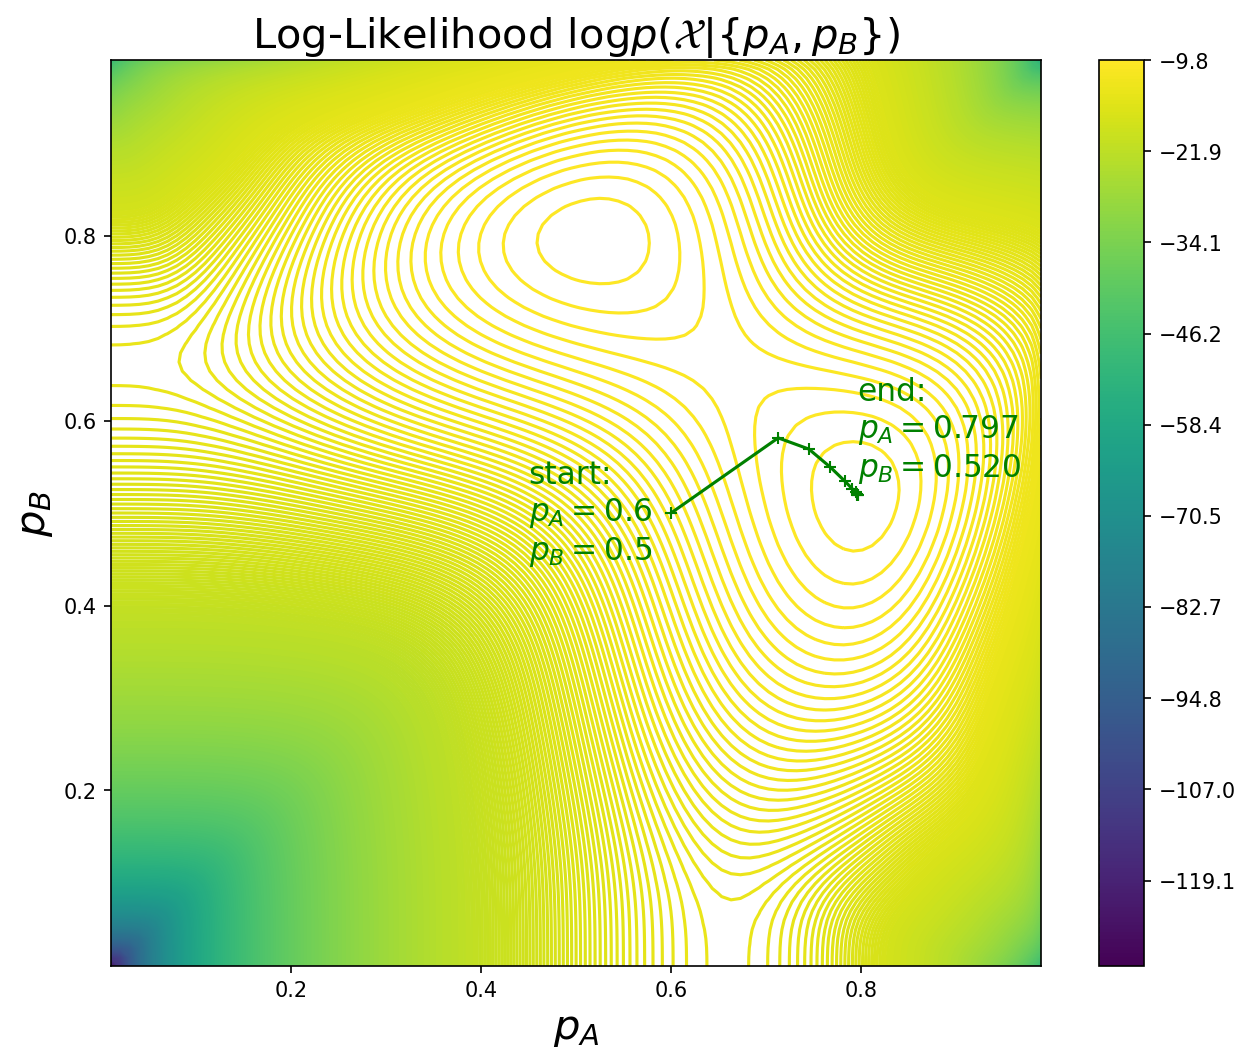

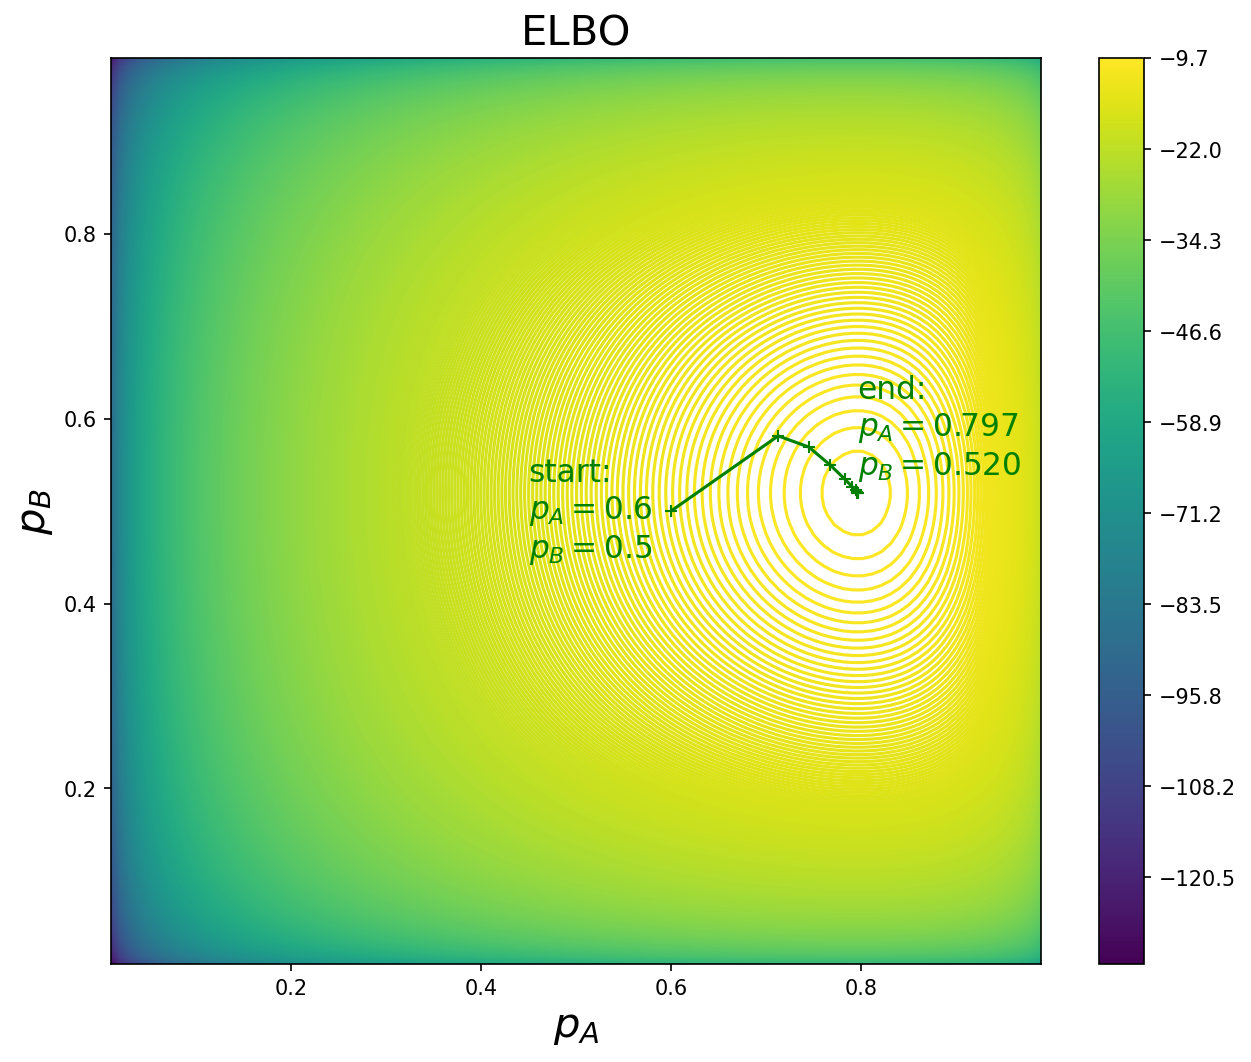

In [13]:
"""Starts the EM algorithm."""

n = 10               # number of tosses per trial
X = [5, 9, 8, 4, 7]  # observation  
lam = 0.5            # prior
p1 = 0.6             # parameter: pA
p2 = 0.5             # parameter: pB
n_trials = len(X)    # number of trials
n_iters = 10         # number of EM iterations

path = [(p1, p2)]
print('Init: theta = {p_A, p_B} = ')
print(p1, p2)

for i in range(n_iters):
    print(f'==========EM Iter: {i + 1}==========')

    # E-step
    q = np.zeros([n_trials, 2])
    for trial in range(n_trials):
        x = X[trial]
        q[trial, 0] = lam * binomial(x, n, p1)
        q[trial, 1] = (1 - lam) * binomial(x, n, p2)
        normalization = q[trial, 0] + q[trial, 1]
        q[trial, 0] /= normalization
        q[trial, 1] /= normalization

    print('E-step: q(z) = ')
    print(q)
    
    # M-step
    p1 = sum((np.array(X) / n) * q[:, 0]) / sum(q[:, 0])
    p2 = sum((np.array(X) / n) * q[:, 1]) / sum(q[:, 1])

    path.append([p1, p2])

    print('M-step: theta = ')
    print(p1, p2)

plot_coin_likelihood(X, n, path)
plot_coin_ELBO(X, n, q, path)